In [1]:
import re
import json
import spacy
import torch
import openai
import vertexai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer
from pinecone import Pinecone, ServerlessSpec
from vertexai.language_models import TextEmbeddingModel
from utils_google import authenticate
credentials, PROJECT_ID, service_account, pinecone_API_KEY = authenticate() 
from utils_openai import authenticate
OPENAI_API_KEY = authenticate() 

openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)

REGION = "us-central1"
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

pc = Pinecone(api_key=pinecone_API_KEY)

# download spacy model
#!python -m spacy download en_core_web_sm

In [119]:
recipes = pd.read_json("recipes_v1.json")
recipes.head()

,title,date,tags,introduction,ingredients,direction,output
0,Creamy Mashed Potatoes,2021-03-12,"[potato, side, cheesefare]",![Creamy Mashed Potatoes](/pix/creamy-mashed-p...,The quantities here are for about four adult p...,1. Peel and cut the potatoes into medium sized...,"{'title': 'Creamy Mashed Potatoes', 'ingredien..."
1,Red Sauce (Ragu all'Italiana),2021-03-16,"[italian, sauce]",My great-grandma's red sauce. All purpose: goo...,- 1/3 lb salt pork - 2 lb chuck roast - 3 Clov...,"1. Mince the garlic, peel the carrot, peel and...","{'title': 'Red Sauce (Ragu all'Italiana)', 'in..."
2,Turmeric Flatbread,2022-08-09,"[bread, turkish]",A great companion to Turkish Red Lentil Soup. ...,- 1 cup Wheat Flour (white or whole) - 1/2 Tbs...,"1. Combine flour, turmeric, salt and baking po...","{'title': 'Turmeric Flatbread', 'ingredients':..."
3,Zurich-Style Meat Saute,2023-01-06,"[beef, cream, swiss, quick]","Originally called ""Züri Gschnätzlets"" (Zurich ...","- 600g\tBeef, finely sliced - 250g\tMushrooms,...",1. Fry the meat in butter at high heat until i...,"{'title': 'Zurich-Style Meat Saute', 'ingredie..."
4,Tuscan Style Pork Roast,2021-03-10,"[italian, pork, roast]",![tuscan-style-pork-roast](/pix/tuscan-style-p...,- 1 pork Roast - 2-3 Tbsp fresh rosemary - 8 c...,1.\tPreheat oven to 275°F (135°C) 2.\tButterfl...,"{'title': 'Tuscan Style Pork Roast', 'ingredie..."


In [120]:
def replace_units(text):
    text = text.replace("lbs", "")
    text = text.replace("lb", "")
    text = text.replace("cups", "")
    text = text.replace("Cups", "")
    text = text.replace("cup", "")
    text = text.replace("Cup", "")
    text = text.replace("tbsp", "")
    text = text.replace("Tbsp", "")
    text = text.replace("tsp", "")
    text = text.replace("Tsp", "")
    text = text.replace("kg", "")
    return text

recipes["introduction"] = recipes.introduction.apply(lambda recipe: "".join([x for x in recipe.split("- ") if not re.search("[0-9]+", x)]))
recipes["ingredients"] = recipes.ingredients.apply(lambda x: replace_units(re.sub("[0-9]*/?-?[0-9]*", "", x)))

In [126]:
context = {"role": "system",
           "content": """based on the input decide if the recipe is vegetarian-friendly, vegan-friendly, or regular. Return a valid Python dictionary in the format {"recipe_type": value} \
            value is "vegan" if all ingredients are plant-based, "vegetarian" if there are plant-based, dairy based, eggs and honey are part of the ingredients but no meat or fish and if meat or fish is included "regular" """}


def recipe_classifier(context, message):
  messages = [context]
  messages.append({"role": "user",
                   "content": message})

  response = openai_client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=messages,
    temperature=0.0,
    max_tokens=10,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return json.loads(response.choices[0].message.content)

In [127]:
recipes["recipe_type"] = recipes.ingredients.apply(lambda x: recipe_classifier(context, x).get("recipe_type")) 

In [144]:
with open("recipes_v2.json", "w", encoding="utf8") as json_file:
    json_file.write(recipes.to_json(orient="records", force_ascii=False))

In [2]:
recipes = pd.read_json("recipes_v2.json")
recipes.head()

,title,date,tags,introduction,ingredients,direction,output,recipe_type
0,Creamy Mashed Potatoes,2021-03-12,"[potato, side, cheesefare]",![Creamy Mashed Potatoes](/pix/creamy-mashed-p...,The quantities here are for about four adult p...,1. Peel and cut the potatoes into medium sized...,"{'title': 'Creamy Mashed Potatoes', 'ingredien...",regular
1,Red Sauce (Ragu all'Italiana),2021-03-16,"[italian, sauce]",My great-grandma's red sauce. All purpose: goo...,salt pork chuck roast Cloves of garlic...,"1. Mince the garlic, peel the carrot, peel and...","{'title': 'Red Sauce (Ragu all'Italiana)', 'in...",regular
2,Turmeric Flatbread,2022-08-09,"[bread, turkish]",A great companion to Turkish Red Lentil Soup.,Wheat Flour (white or whole) Ground Turm...,"1. Combine flour, turmeric, salt and baking po...","{'title': 'Turmeric Flatbread', 'ingredients':...",vegetarian
3,Zurich-Style Meat Saute,2023-01-06,"[beef, cream, swiss, quick]","Originally called ""Züri Gschnätzlets"" (Zurich ...","g\tBeef, finely sliced g\tMushrooms, finely ...",1. Fry the meat in butter at high heat until i...,"{'title': 'Zurich-Style Meat Saute', 'ingredie...",regular
4,Tuscan Style Pork Roast,2021-03-10,"[italian, pork, roast]",![tuscan-style-pork-roast](/pix/tuscan-style-p...,pork Roast fresh rosemary cloves garlic...,1.\tPreheat oven to 275°F (135°C) 2.\tButterfl...,"{'title': 'Tuscan Style Pork Roast', 'ingredie...",regular


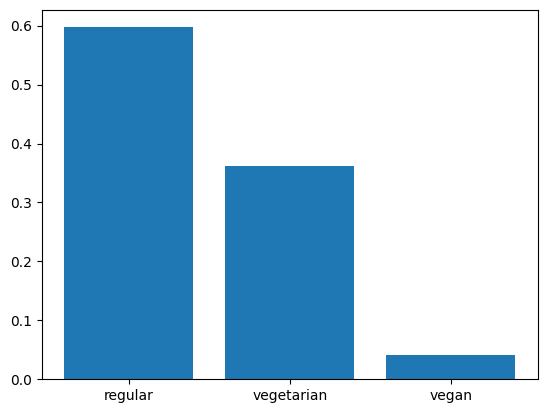

In [3]:
plt.bar(recipes.recipe_type.unique(), recipes.recipe_type.value_counts(normalize=True).values)
plt.show()

In [4]:
recipes["dense_feature"] = recipes.title + "; " + recipes.tags.apply(lambda x: str(x).strip("[]").replace("'", "")) + "; " + recipes.introduction
recipes["dense_feature"].head()

0    Creamy Mashed Potatoes; potato, side, cheesefa...
1    Red Sauce (Ragu all'Italiana); italian, sauce;...
2    Turmeric Flatbread; bread, turkish; A great co...
3    Zurich-Style Meat Saute; beef, cream, swiss, q...
4    Tuscan Style Pork Roast; italian, pork, roast;...
Name: dense_feature, dtype: object

In [5]:
recipes.iloc[0].output

{'title': 'Creamy Mashed Potatoes',
 'ingredients': 'The quantities here are for about four adult portions. If you are planning on eating this as a side dish, it might be more like 6-8 portions. * 1kg potatoes * 200ml milk* * 200ml mayonnaise* * ~100g cheese * Garlic powder * 12-16 strips of bacon * Butter * 3-4 green onions * Black pepper * Salt  *You can play with the proportions depending on how creamy or dry you want the mashed potatoes to be.',
 'direction': '1. Peel and cut the potatoes into medium sized pieces. 2. Put the potatoes in a pot with some water so that it covers the potatoes and   boil them for about 20-30 minutes, or until the potatoes are soft. 3. About ten minutes before removing the potatoes from the boiling water, cut   the bacon into little pieces and fry it. 4. Warm up the milk and mayonnaise. 5. Shred the cheese. 6. When the potatoes are done, remove all water from the pot, add the warm milk   and mayonnaise mix, add some butter, and mash with a potato masher 

In [6]:
recipes["ID"] = range(len(recipes))
recipes.head()

,title,date,tags,introduction,ingredients,direction,output,recipe_type,dense_feature,ID
0,Creamy Mashed Potatoes,2021-03-12,"[potato, side, cheesefare]",![Creamy Mashed Potatoes](/pix/creamy-mashed-p...,The quantities here are for about four adult p...,1. Peel and cut the potatoes into medium sized...,"{'title': 'Creamy Mashed Potatoes', 'ingredien...",regular,"Creamy Mashed Potatoes; potato, side, cheesefa...",0
1,Red Sauce (Ragu all'Italiana),2021-03-16,"[italian, sauce]",My great-grandma's red sauce. All purpose: goo...,salt pork chuck roast Cloves of garlic...,"1. Mince the garlic, peel the carrot, peel and...","{'title': 'Red Sauce (Ragu all'Italiana)', 'in...",regular,"Red Sauce (Ragu all'Italiana); italian, sauce;...",1
2,Turmeric Flatbread,2022-08-09,"[bread, turkish]",A great companion to Turkish Red Lentil Soup.,Wheat Flour (white or whole) Ground Turm...,"1. Combine flour, turmeric, salt and baking po...","{'title': 'Turmeric Flatbread', 'ingredients':...",vegetarian,"Turmeric Flatbread; bread, turkish; A great co...",2
3,Zurich-Style Meat Saute,2023-01-06,"[beef, cream, swiss, quick]","Originally called ""Züri Gschnätzlets"" (Zurich ...","g\tBeef, finely sliced g\tMushrooms, finely ...",1. Fry the meat in butter at high heat until i...,"{'title': 'Zurich-Style Meat Saute', 'ingredie...",regular,"Zurich-Style Meat Saute; beef, cream, swiss, q...",3
4,Tuscan Style Pork Roast,2021-03-10,"[italian, pork, roast]",![tuscan-style-pork-roast](/pix/tuscan-style-p...,pork Roast fresh rosemary cloves garlic...,1.\tPreheat oven to 275°F (135°C) 2.\tButterfl...,"{'title': 'Tuscan Style Pork Roast', 'ingredie...",regular,"Tuscan Style Pork Roast; italian, pork, roast;...",4


## Generate sparse embeddings

In [7]:
model_id = "naver/splade-cocondenser-ensembledistil"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

In [8]:
def to_sparse_vector(text, tokenizer, model):
    tokens = tokenizer(text, return_tensors='pt')
    output = model(**tokens)
    vec = torch.max(
        torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
    )[0].squeeze()

    cols = vec.nonzero().squeeze().cpu().tolist()
    weights = vec[cols].cpu().tolist()
    sparse_dict = dict(zip(cols, weights))
    return sparse_dict
    
sparse_vectors = []

for i in tqdm(range(len(recipes))):
    sparse_vectors.append(to_sparse_vector(recipes.iloc[i]["ingredients"], tokenizer, model))

recipes["sparse_vectors"] = sparse_vectors

  0%|          | 0/360 [00:00<?, ?it/s]

In [9]:
recipes.iloc[0].sparse_vectors

{1018: 0.256075918674469,
 1043: 0.27197131514549255,
 2004: 0.37481558322906494,
 2007: 0.3710925579071045,
 2017: 0.4206917881965637,
 2022: 0.3592374920845032,
 2023: 0.32909026741981506,
 2052: 0.08959243446588516,
 2066: 1.118770718574524,
 2116: 0.824336588382721,
 2172: 0.38699254393577576,
 2176: 0.6553488969802856,
 2182: 0.5147400498390198,
 2191: 0.19235864281654358,
 2215: 0.1018514484167099,
 2217: 1.6541664600372314,
 2304: 0.7942245602607727,
 2377: 0.5490118265151978,
 2561: 0.636225700378418,
 2652: 0.03633405640721321,
 2665: 0.8123427629470825,
 2833: 0.34750956296920776,
 2862: 0.26289740204811096,
 2933: 0.04944736883044243,
 3033: 0.2645045816898346,
 3129: 0.1931634098291397,
 3357: 0.3081265687942505,
 3528: 0.012617050670087337,
 3529: 0.42014896869659424,
 3531: 0.17510782182216644,
 3635: 0.539874255657196,
 3815: 0.28908294439315796,
 3829: 0.048400625586509705,
 3903: 0.761964738368988,
 4041: 0.57978355884552,
 4109: 0.17649239301681519,
 4118: 0.087742194

## Generate dense embeddings

### Using VertexAI

In [10]:
# running this code will create costs !!!
model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")

def to_dense_vector(text, model):
    dense_vectors = model.get_embeddings([text])
    return [dense_vector.values for dense_vector in dense_vectors][0]

dense_vectors = []

for i in tqdm(range(len(recipes))):
    dense_vectors.append(to_dense_vector(recipes.iloc[i]["dense_feature"], model))

recipes["dense_vectors"] = dense_vectors

  0%|          | 0/360 [00:00<?, ?it/s]

In [11]:
recipes.to_pickle("recipes_with_vectors.pkl")

### Using OpenAI

In [ ]:
# running this code will create costs !!!

# Create dense embeddings using OpenAIs text embedding model with 768 dimensions
model = "text-embedding-3-small"

def to_dense_vector_openAI(text, client, model, dimensions):
    dense_vectors = client.embeddings.create(model=model, dimensions=dimensions, input=[text])
    return [dense_vector.values for dense_vector in dense_vectors][0]

dense_vectors = []

for i in tqdm(range(len(recipes))):
    dense_vectors.append(to_dense_vector_openAI(recipes.iloc[i]["dense_feature"], openai_client, model, 768))

recipes["dense_vectors"] = dense_vectors

In [ ]:
recipes = pd.read_pickle("recipes_with_vectors.pkl")

## Upsert sparse and dense embeddings to Pinecone vector database

In [12]:
# if you need to delte an existing index

pc.delete_index("coffee-project")

In [13]:
pc.create_index(
    name="recipe-project",
    dimension=768,
    metric="dotproduct",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-west-2"
    )
)

pc.describe_index("recipe-project")

{'dimension': 768,
 'host': 'recipe-project-4f4fwfa.svc.apw5-4e34-81fa.pinecone.io',
 'metric': 'dotproduct',
 'name': 'recipe-project',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-west-2'}},
 'status': {'ready': True, 'state': 'Ready'}}

In [14]:
def sparse_to_dict(data):
    dict_ = {"indices": list(data.keys()),
             "values": list(data.values())}
    return dict_

batch_size = 100
index = pc.Index("recipe-project")

for i in tqdm(range(0, len(recipes), batch_size)):
    i_end = min(i + batch_size, len(recipes))
    meta_batch = recipes.iloc[i: i_end][["ID", "recipe_type"]]
    meta_dict = meta_batch.to_dict(orient="records")

    sparse_batch = recipes.iloc[i: i_end]["sparse_vectors"].apply(lambda x: sparse_to_dict(x))
    dense_batch = recipes.iloc[i: i_end]["dense_vectors"]

    upserts = []

    ids = [str(x) for x in range(i, i_end)]
    for id_, meta, sparse_, dense_ in zip(ids, meta_dict, sparse_batch, dense_batch):
        upserts.append({
            "id": id_,
            "sparse_values": sparse_,
            "values": dense_,
            "metadata": meta
        })

    index.upsert(upserts)

index.describe_index_stats()

  0%|          | 0/4 [00:00<?, ?it/s]

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 360}},
 'total_vector_count': 360}

In [16]:
index.fetch(ids=["50"])

{'namespace': '',
 'usage': {'read_units': 1},
 'vectors': {'50': {'id': '50',
                    'metadata': {'ID': 50.0, 'recipe_type': 'vegetarian'},
                    'sparse_values': {'indices': [1015,
                                                  1043,
                                                  1059,
                                                  1092,
                                                  2102,
                                                  2140,
                                                  2290,
                                                  2317,
                                                  2431,
                                                  2762,
                                                  2828,
                                                  2833,
                                                  2862,
                                                  3528,
                                                  3635,
      

## Search

### Regular search using dense vector

In [53]:
user_query = "I want to cook a Italian dish"
recipe_type = ["vegetarian"]

In [54]:
# running this code will create costs !!!

# If you used VertexAI and gecko003 to create dense embeddings
model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")

text_dense_vector = to_dense_vector(user_query, model)

In [ ]:
# running this code will create costs !!!

# If you used OpenAI to create dense embeddings
model = "text-embedding-3-small"

text_dense_vector = to_dense_vector_openAI(user_query, openai_client, model, 768)

In [55]:
retrieved_items = index.query(vector=text_dense_vector,
                              include_values=False,
                              include_metadata=True,
                              top_k=3,
                              filter={"recipe_type": {"$in": recipe_type}})

retrieved_ids = [item.get("metadata").get("ID") for item in retrieved_items.get("matches")]

retrieved_items

{'matches': [{'id': '144',
              'metadata': {'ID': 144.0, 'recipe_type': 'vegetarian'},
              'score': 0.74672693,
              'values': []},
             {'id': '61',
              'metadata': {'ID': 61.0, 'recipe_type': 'vegetarian'},
              'score': 0.734683216,
              'values': []},
             {'id': '286',
              'metadata': {'ID': 286.0, 'recipe_type': 'vegetarian'},
              'score': 0.729948819,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}

In [43]:
recipes[recipes.ID.isin(retrieved_ids)].output.values

array([{'title': 'Pasta Arrabbiata', 'ingredients': '- Pasta - Olive oil - Chilli flakes or diced chilli peppers - Crushed garlic cloves - Crushed tomatoes (about 800 gramms for 500 gramms of pasta) - Chopped parsley - Grated Pecorino Romano or Parmigiano Reggiano (optional, but highly recommended)', 'direction': '1. Start heating up water for the pasta. 2. Heat up a few tablespoons of olive oil over low heat. 3. Crush several cloves of garlic into the olive oil, add the chilli flakes or chilli peppers and fry them for a short time, while being careful not to burn the garlic. 4. Add your crushed tomatoes, together with some salt and pepper, increase the heat to medium and let simmer for 10-15 minutes or until it looks nicely thickened. 5. When the water starts boiling, put a handful of salt into it and then your pasta of choice. Ideally leave the pasta slightly undercooked, because it will go in the hot sauce and finish cooking there. 6. When the sauce is almost ready, add most of your

In [44]:
recipes[recipes.ID.isin(retrieved_ids)].output.values[0]

{'title': 'Pasta Arrabbiata',
 'ingredients': '- Pasta - Olive oil - Chilli flakes or diced chilli peppers - Crushed garlic cloves - Crushed tomatoes (about 800 gramms for 500 gramms of pasta) - Chopped parsley - Grated Pecorino Romano or Parmigiano Reggiano (optional, but highly recommended)',
 'direction': '1. Start heating up water for the pasta. 2. Heat up a few tablespoons of olive oil over low heat. 3. Crush several cloves of garlic into the olive oil, add the chilli flakes or chilli peppers and fry them for a short time, while being careful not to burn the garlic. 4. Add your crushed tomatoes, together with some salt and pepper, increase the heat to medium and let simmer for 10-15 minutes or until it looks nicely thickened. 5. When the water starts boiling, put a handful of salt into it and then your pasta of choice. Ideally leave the pasta slightly undercooked, because it will go in the hot sauce and finish cooking there. 6. When the sauce is almost ready, add most of your chop

### Hybrid search

In [88]:
user_query = "What can I cook with potatos, mushrooms, and beef?"
recipe_type = ["regular", "vegetarian", "vegan"]

In [89]:
model_id = "naver/splade-cocondenser-ensembledistil"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

text_sparse_vector = to_sparse_vector(user_query, tokenizer, model)

In [90]:
def hybride_search(sparse_dict, dense_vectors, alpha):

    # check alpha value is in range
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        "indices": list(sparse_dict.keys()),
        "values": [v * (1 - alpha) for v in list(sparse_dict.values())]
    }
    hdense = [v * alpha for v in dense_vectors]
    return hdense, hsparse

In [99]:
dense_vector, sparse_dict = hybride_search(text_sparse_vector, text_dense_vector, 1.0)

retrieved_items = index.query(vector=dense_vector,
                              sparse_vector=sparse_dict,
                              include_values=False,
                              include_metadata=True,
                              top_k=1,
                              filter={"recipe_type": {"$in": recipe_type}})

retrieved_ids = [item.get("metadata").get("ID") for item in retrieved_items.get("matches")]

retrieved_items

{'matches': [{'id': '211',
              'metadata': {'ID': 211.0, 'recipe_type': 'regular'},
              'score': 0.790846229,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}

In [100]:
[x.get("ingredients") for x in recipes[recipes.ID.isin(retrieved_ids)].output.values]

['- extra virgin olive oil - 2 carrots - 2 celery sticks - 1 large onion - 2 garlic cloves (optional, but not traditional) - 200 grams pancetta (optional) - 300 grams beef mince - 350 grams pork mince - 350 grams veal mince (if you cant find veal replace with pork) - 140 grams concentrated tomato paste - 690 grams diced tomatoes - water - 1 can peeled tomatoes - 1-2 glasses wine (whatever you have open) - 1 glass of milk (optional) - 1 glass of beef/vegetable stock (optional)']

In [103]:
model_id = "naver/splade-cocondenser-ensembledistil"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

text_sparse_vector = to_sparse_vector(user_query, tokenizer, model)

dense_vector, sparse_dict = hybride_search(text_sparse_vector, text_dense_vector, 0.5)

retrieved_items = index.query(vector=dense_vector,
                              sparse_vector=sparse_dict,
                              include_values=False,
                              include_metadata=True,
                              top_k=1,
                              filter={"recipe_type": {"$in": recipe_type}})

retrieved_ids = [item.get("metadata").get("ID") for item in retrieved_items.get("matches")]

[x.get("ingredients") for x in recipes[recipes.ID.isin(retrieved_ids)].output.values]

['* 500g beef * 300-400g potatoes * 1 carrot * 1 medium onion * 12 tablespoons tomato paste * 500ml water * 3-4 garlic cloves * 3-4 bay leaves * Curcuma * Paprika * Oregano * Parsley * Caraway * Basil (optional) * Cilantro (optional) * 2-3 champignon mushrooms (optional)']